In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob
import os

import rasterio
from rasterio.plot import show as rioshow
from geospatial_functions import get_background_map
from geospatial_functions import reproject_raster

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
gis_folder = f'{home_path}\\GIS'
data_folder = f'{home_path}\\Data'

In [3]:
def align_zeros(axes):
    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas
    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
        
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))

## load meteorological data

In [4]:
files = glob.glob(f"{data_folder}\\*.parquet")
files


['C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\combined_data.parquet',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\df_combined_data.parquet',
 'C:\\Users\\david\\Documents\\@@ Python\\Jaar 5\\Q3\\ENVM1502\\Git\\ENVM1502-Catchment-model\\Data\\df_data.parquet']

In [5]:
df_all_data = pd.read_parquet(files)
df_all_data.head();

not all years have 365 observations, so exclude anything before 1894

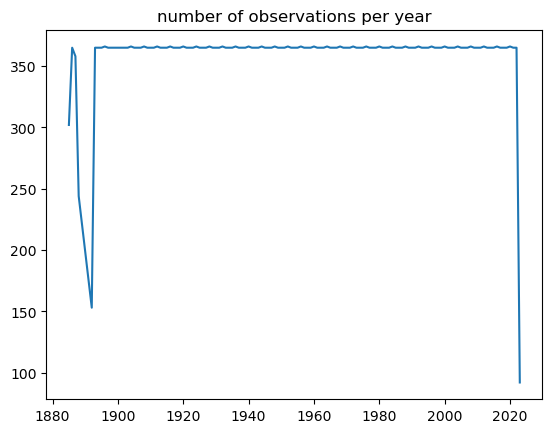

In [6]:
lst = []
for year in df_all_data.index.year.unique():
    lst.append([year,sum(df_all_data.index.year==year)])
plt.plot(np.array(lst)[:,0],np.array(lst)[:,1])
plt.title("number of observations per year");

This only take from 1894, due to missing days and to remove the remove gap between 1988 and 1892

In [7]:
df_all_data = df_all_data.loc[pd.Timestamp("1894-01-01"):]

Plot these data

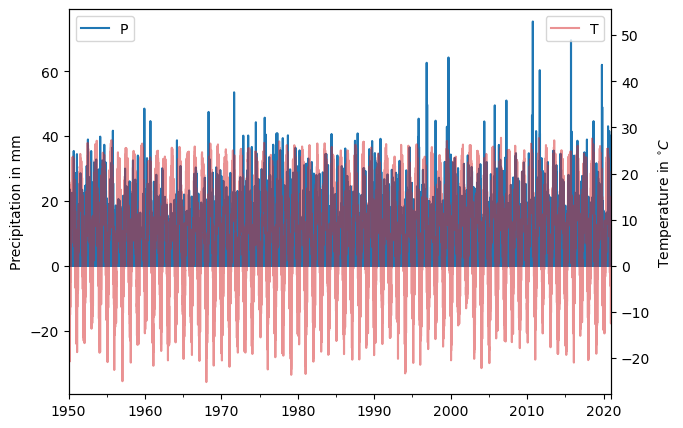

In [8]:
df_T_P = df_all_data[["T","P"]].dropna(axis=0)

fig, ax = plt.subplots(1,1,figsize=(7,5),sharex=True)
df_T_P[['P']].plot(ax=ax,alpha=1)
ax.set_ylabel("Precipitation in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_T_P[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2]);

# Consider elevation data as this correlates with snow

### From dem

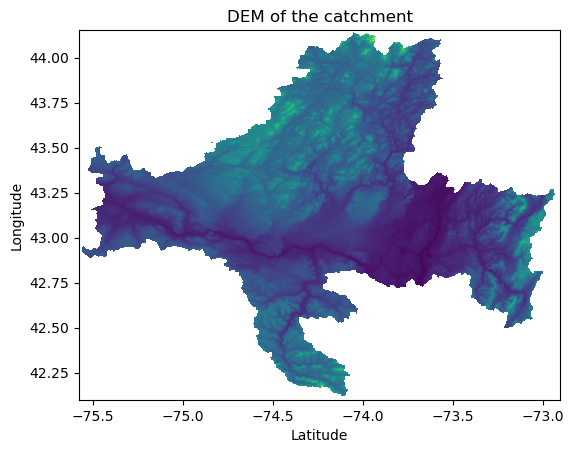

In [9]:
fig, ax = plt.subplots(1)
path = f'{gis_folder}\\basin_dem_SRTM.tif'
new_path = reproject_raster(path, "EPSG:4326")
with rasterio.open(new_path, driver='GTiff') as r:
        rioshow(r, ax=ax)
ax.set_title("DEM of the catchment")
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude");

In [10]:
with rasterio.open(
    new_path,
    driver='GTiff',
    count=1,
    crs='EPSG:4326' 
                    ) as r:
    dem_data = r.read(1)

From the station data where the temperature is measured

In [11]:
load_lst_elevation = np.loadtxt(f'{data_folder}\\T\\elevation_stations.txt',delimiter=";",dtype=str)
lst_elevation = load_lst_elevation[:,1].astype(np.float64)

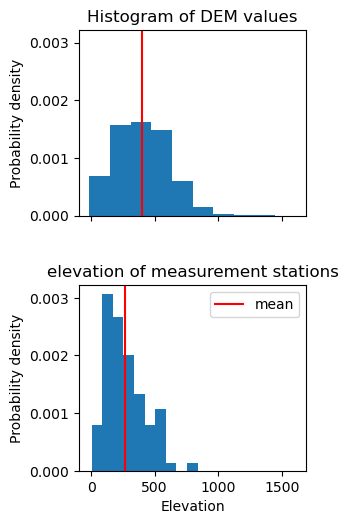

In [12]:
fig, [ax,ax2] = plt.subplots(2,1,sharex=True,sharey=True,figsize=(3,5))
fig.tight_layout(h_pad=4)

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")

_, __, ___ = ax2.hist(lst_elevation,density=True)
ax2.axvline(np.mean(lst_elevation),color="r",label="mean")
ax2.legend()
ax2.set_title("elevation of measurement stations");
ax2.set_ylabel("Probability density")
ax2.set_xlabel("Elevation");

The two histograms above show the distribution of the different elevations. In red the mean is shown. The dem and station measurements are fairly similar, though the stations measure a bit lower. 

###  Start by taking the mean heights and the mean temperature as one flat plane

function to get index of the day before

In [13]:
def prev_date(date, days=1):    
    subtracted_date = pd.to_datetime(date) - datetime.timedelta(days=days)
    subtracted_date = subtracted_date.strftime("%Y-%m-%d")
    return subtracted_date

create snowfall model for this simplified area & run the model

In [14]:
df = df_T_P.copy()

Er = lst_elevation.mean() #m 
Tt = -0.5 # degc
FM = 3    # mm/deg/d
S_0 = 0 # mm - no snow at start

# for every day:
dt = 1
for i, date in enumerate(df.index):
    P  = df.loc[date,"P"]
    TR = df.loc[date,"T"]
    if i == 0:
        df.loc[prev_date(date),"Ss"] = S_0 # initial amount snow (0) for non exisiting day
        
    # if below threshold temperature, assume not first day for similicity
    if TR < Tt and i != 0:
        df.loc[date,"Pr"] = 0                                                     # no rainfall
        df.loc[date,"Ps"] = P                                                     # precipitation is snow 
        df.loc[date,"M"]  = 0                                                     # Too cold for melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] + df.loc[date,"Ps"] * dt # add snow to the prev day
        df.loc[date,"Pl"] = 0                                                     # no outflow as too cold
    # then must be above
    else:
        df.loc[date,"Pr"] = P                                                     # all precip is rainfall
        df.loc[date,"Ps"] = 0                                                     # no snow 
        df.loc[date,"M"]  = min(df.loc[prev_date(date),"Ss"]/dt, FM * (TR - Tt))  # calculate melt
        df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] - df.loc[date,"M"] * dt  # remove melted snow
        df.loc[date,"Pl"] = df.loc[date,"Pr"] + df.loc[date,"M"]                  # outflow = rain + melt
        if i == 0:
            df.drop(index=prev_date(date),inplace=True) #  remove initial amount snow for non exisiting day
        
df_case1 = df.copy()

# plot for 1997-1999

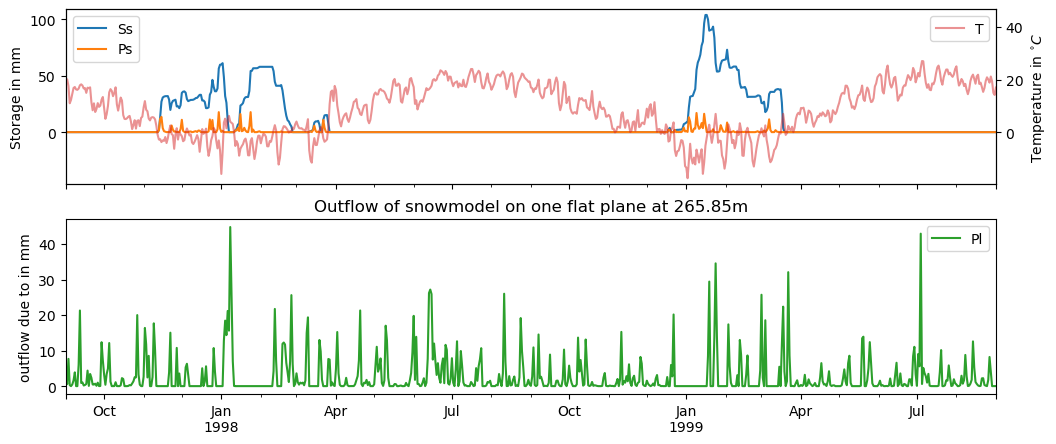

In [15]:
fig, [ax,ax3] = plt.subplots(2,1,figsize=(12,5),sharex=True)
df_plot = df_case1.loc["1997-09-01":"1999-09-01"]
df_plot[['Ss',"Ps"]].plot(ax=ax)
ax.set_ylabel("Storage in mm")
ax.legend(loc="upper left")

ax2 = ax.twinx()
df_plot[["T"]].plot(ax=ax2,color="C3",alpha=0.5,zorder=-10)
ax2.legend(loc="upper right")
ax2.set_ylabel("Temperature in $^{\circ}C$")

align_zeros([ax,ax2])

df_plot[['Pl']].plot(ax=ax3,color="C2")
ax3.set_ylabel("outflow due to in mm")
ax3.set_title(f"Outflow of snowmodel on one flat plane at {Er:.2f}m");


# repeat but with different elevation bands

As we can see bellow, there is a spread of elevation from 0 to around 1000. these can be split into 4 bands:
1. `elevation < 250`
1. `250 < elevation < 500`
1. `500 < elevation < 750`
1. `750 < elevation`

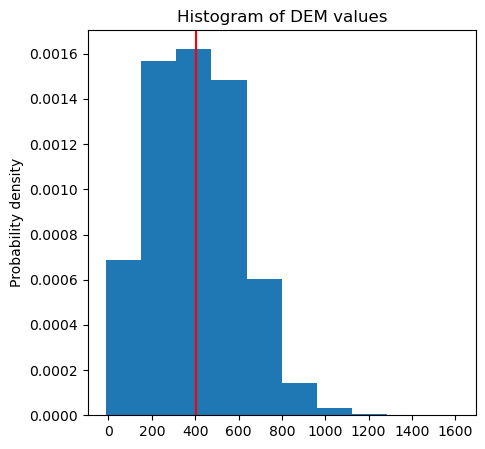

In [16]:
fig, ax = plt.subplots(1,sharex=True,sharey=True,figsize=(5,5))

dem_data_in_basin = dem_data[dem_data>-999]
_, __, ___ = ax.hist(np.sort(dem_data_in_basin),density=True);
ax.axvline(np.mean(dem_data_in_basin),color="r")
ax.set_title("Histogram of DEM values")
ax.set_ylabel("Probability density")
ax.annotate(f"$\mu$ ={np.mean(dem_data_in_basin):.1f}m",(np.mean(dem_data_in_basin)+12,0.002),color="red");

we need to calculate the areas these four bands represent:

In [17]:
A1 = len(dem_data_in_basin[dem_data_in_basin<=250])/ len(dem_data_in_basin)
A2 = len(dem_data_in_basin[(dem_data_in_basin>250) & (dem_data_in_basin <=500)])/ len(dem_data_in_basin)
A3 = len(dem_data_in_basin[(dem_data_in_basin>500) & (dem_data_in_basin <=750)])/ len(dem_data_in_basin)
A4 = len(dem_data_in_basin[(dem_data_in_basin>750)])/ len(dem_data_in_basin)
print(f'A1:\t{A1:.2f}\nA2:\t{A2:.2f}\nA3:\t{A3:.2f}\nA4:\t{A4:.2f}\nΣ:\t{A1 + A2 + A3 + A4:.2f}')

A1:	0.26
A2:	0.40
A3:	0.28
A4:	0.05
Σ:	1.00


In [18]:
# for every day:
dt = 1

Er = 331  # m

heights = [125, 375, 625, 875] # m
A_lst = [A1, A2, A3, A4]
A = sum(A_lst)

lst_df         = []
lst_df_storage = []
for A_index, Ei in enumerate(heights): 
    df = df_T_P.copy()
    # compute for each day
    for i, date in enumerate(df.index):
        P  = df.loc[date,"P"]
        TR = df.loc[date,"T"]
        Ti = TR - 0.6 * (Ei-Er) / 100
        
        if i == 0:
            df.loc[prev_date(date),"Ss"] = S_0 # initial amount snow (0) for non exisiting day

        # if below threshold temperature, assume not first day for similicity
        if Ti < Tt and i != 0:
            df.loc[date,"Pr"] = 0                                                     # no rainfall
            df.loc[date,"Ps"] = P                                                     # precipitation is snow 
            df.loc[date,"M"]  = 0                                                     # Too cold for melt
            df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] + df.loc[date,"Ps"] * dt # add snow to the prev day
            df.loc[date,"Pl"] = 0                                                     # no outflow as too cold
        # then must be above
        else:
            df.loc[date,"Pr"] = P                                                     # all precip is rainfall
            df.loc[date,"Ps"] = 0                                                     # no snow 
            df.loc[date,"M"]  = min(df.loc[prev_date(date),"Ss"]/dt, FM * (Ti - Tt))  # calculate melt
            df.loc[date,"Ss"] = df.loc[prev_date(date),"Ss"] - df.loc[date,"M"] * dt  # remove melted snow
            df.loc[date,"Pl"] = df.loc[date,"Pr"] + df.loc[date,"M"]                  # outflow = rain + melt
            if i == 0:
                df.drop(index=prev_date(date),inplace=True) #  remove initial amount snow for non exisiting day
    # for each height aggregate:
    fi = A_lst[A_index]/A
    df["Pl"] = df.apply(lambda x : x.Pl * fi, axis=1)
    df_out = df[["Pl"]].rename(columns={"Pl":f"Pl_{A_index+1}"})
    lst_df.append(df_out)
    
    df["Ss_scaled"] = df.apply(lambda x : x.Ss * fi, axis=1)
    df_storage_out = df[["Ss","Ss_scaled"]].rename(columns={"Ss":f"Ss_{A_index+1}","Ss_scaled":f"Ss_scaled_{A_index+1}"})
    lst_df_storage.append(df_storage_out)

df_case2 = pd.concat(lst_df + lst_df_storage, axis=1)
df_case2["Pl_tot"] = df_case2.apply(lambda x : x.Pl_1 + x.Pl_2 + x.Pl_3 + x.Pl_4, axis=1)
df_case2["Ss_tot"] = df_case2.apply(lambda x : x.Ss_scaled_1 + x.Ss_scaled_2 + x.Ss_scaled_3 + x.Ss_scaled_4, axis=1)

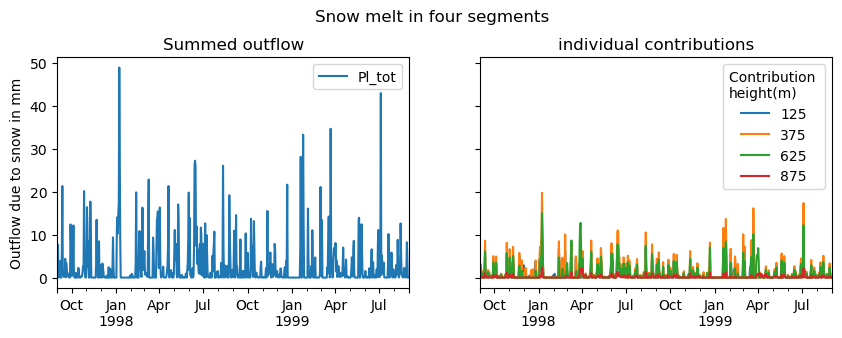

In [19]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,3))
fig.suptitle("Snow melt in four segments",y=1.04)

df_plot = df_case2.loc["1997-09-01":"1999-09-01"]
df_plot[['Pl_tot']].plot(ax=ax[0])
ax[0].set_ylabel("Outflow due to snow in mm")
ax[0].set_title("Summed outflow")
df_plot[['Pl_1','Pl_2','Pl_3','Pl_4']].plot(ax=ax[1])
ax[1].legend(heights,bbox_to_anchor=(1,1),title="Contribution \nheight(m)")
ax[1].set_title("individual contributions");

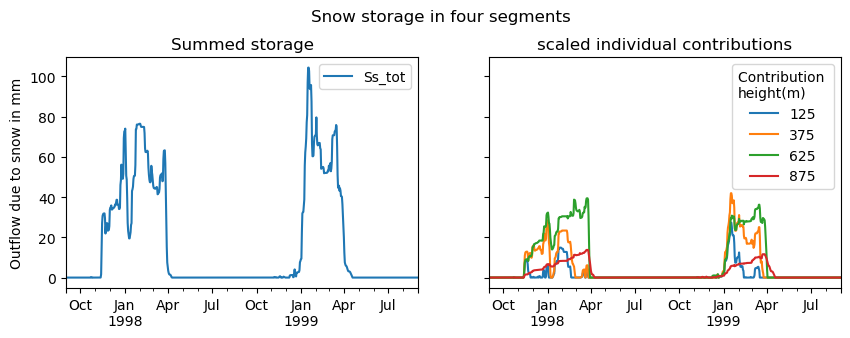

In [20]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,3))
fig.suptitle("Snow storage in four segments",y=1.04)

df_plot = df_case2.loc["1997-09-01":"1999-09-01"]
df_plot[['Ss_tot']].plot(ax=ax[0])
ax[0].set_ylabel("Outflow due to snow in mm")
ax[0].set_title("Summed storage")
df_plot[['Ss_scaled_1','Ss_scaled_2','Ss_scaled_3','Ss_scaled_4']].plot(ax=ax[1])
ax[1].legend(heights,bbox_to_anchor=(1,1),title="Contribution \nheight(m)")
ax[1].set_title("scaled individual contributions");